In [166]:
#Exploratory analysis of the power market and arbitrary investment analysis based on electricity prices
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [3]:
filename = 'data/Power_Market_Data_11_16.csv'
delim = ";"
data = pd.read_csv(filename, sep=delim)
data.head()

,Date,Month,Day,Hour,SYS,SE1,SE2,SE3,SE4,DEMAND,...,Heat_other,Unspec,Sun,SUPPLY,IMPORT,Temp,No_hydro,SE_hydro,FI_hydro,Week
0,2011-01-02,1,7,1,NaN,NaN,NaN,778.95,NaN,-16488.845760,...,1878.390502,1.3743,0.003,15449.309282,1038.7297,-3.5,NaN,NaN,NaN,NaN
1,2011-01-02,1,7,2,NaN,NaN,NaN,746.01,NaN,-16337.272125,...,1920.229341,1.3404,0.002,15323.503929,1013.0168,-3.7,NaN,NaN,NaN,NaN
2,2011-01-02,1,7,3,NaN,NaN,NaN,734.46,NaN,-16329.520536,...,1949.179294,1.3478,0.003,15449.399052,879.4224,-3.7,NaN,NaN,NaN,NaN
3,2011-01-02,1,7,4,NaN,NaN,NaN,738.57,NaN,-16466.559913,...,1940.648825,1.3537,0.002,15470.430006,994.9617,-3.7,NaN,NaN,NaN,NaN
4,2011-01-02,1,7,5,NaN,NaN,NaN,741.44,NaN,-16643.678798,...,1928.890902,1.4186,0.003,15411.277566,1231.5175,-3.9,NaN,NaN,NaN,NaN


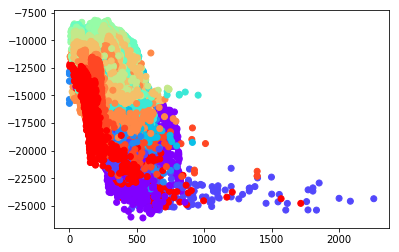

In [4]:
subdata = data[["SE3","DEMAND","Month"]]
subdata.head()
plt.scatter(subdata.iloc[:,0],subdata.iloc[:,1],c=subdata.iloc[:,2],cmap="rainbow")

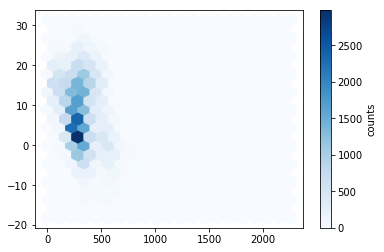

In [5]:
plt.hexbin(data["SE3"], data["Temp"], gridsize=20, cmap='Blues')
cb = plt.colorbar(label='counts')

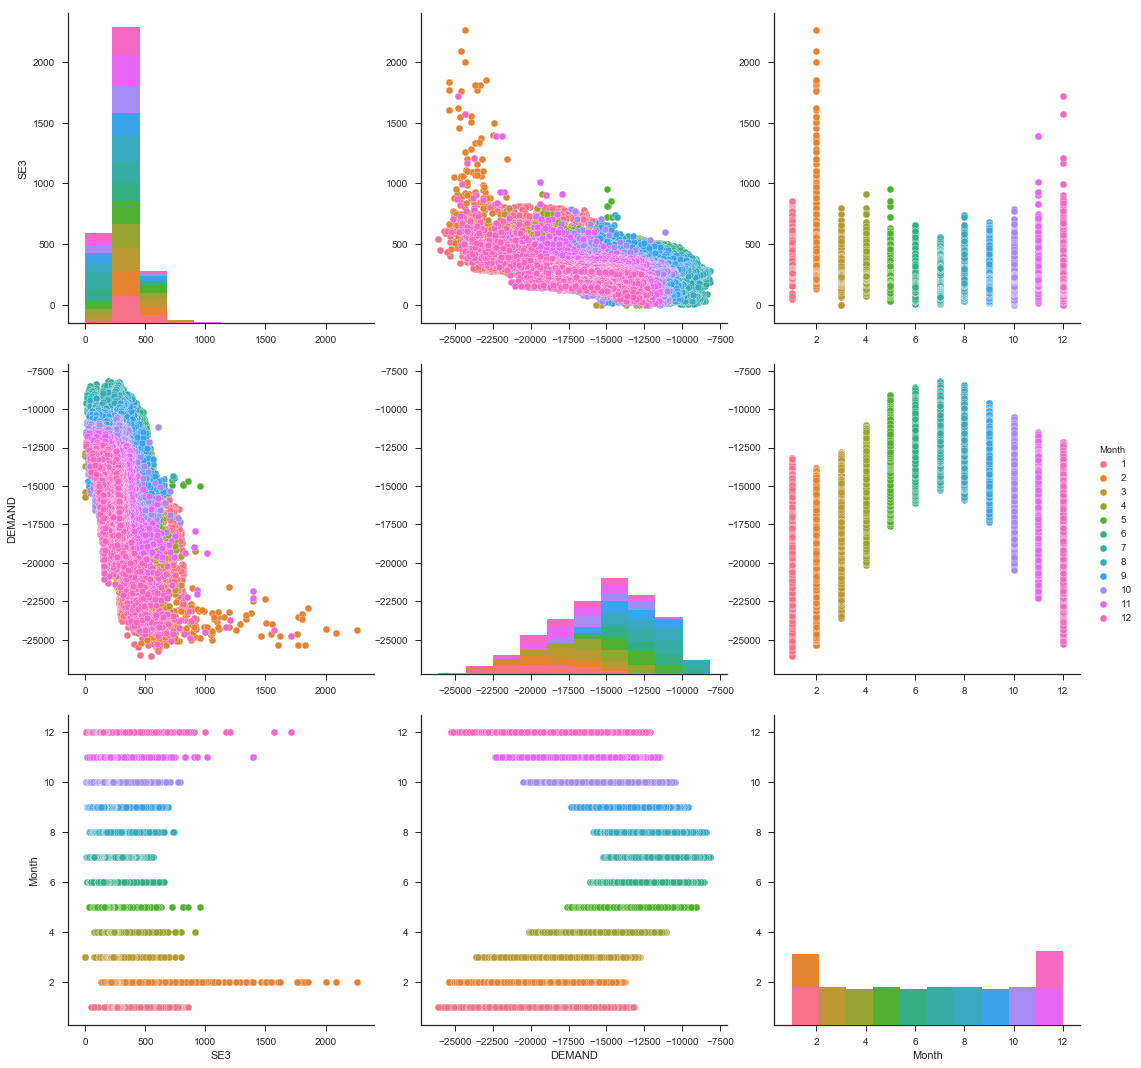

In [141]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(subdata, hue="Month",size=5,vars=["SE3","DEMAND"],diag_kind="hist")
sns.pairplot(subdata, hue="Month",size=5, diag_kind="hist")

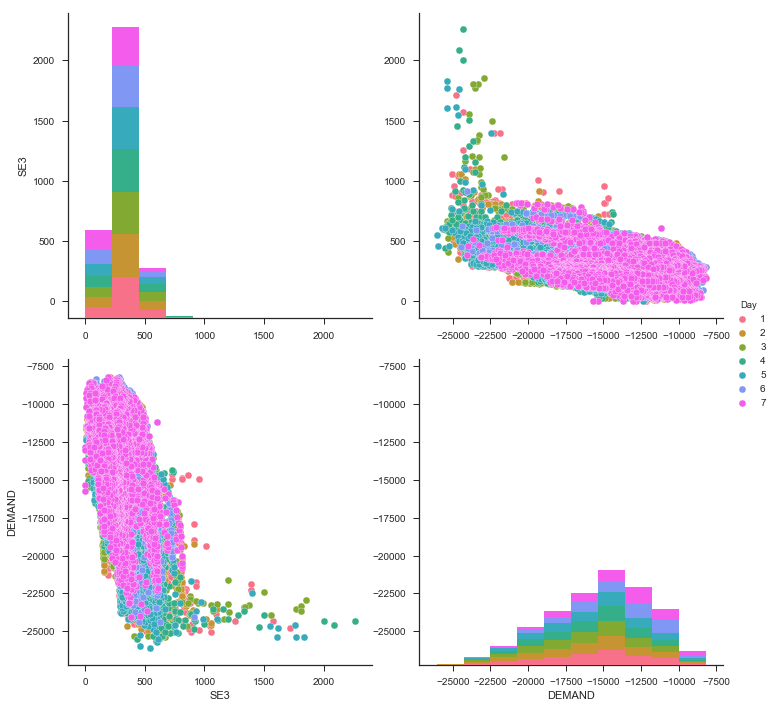

In [131]:
sns.pairplot(data, hue="Day",size=5,vars=["SE3","DEMAND"])

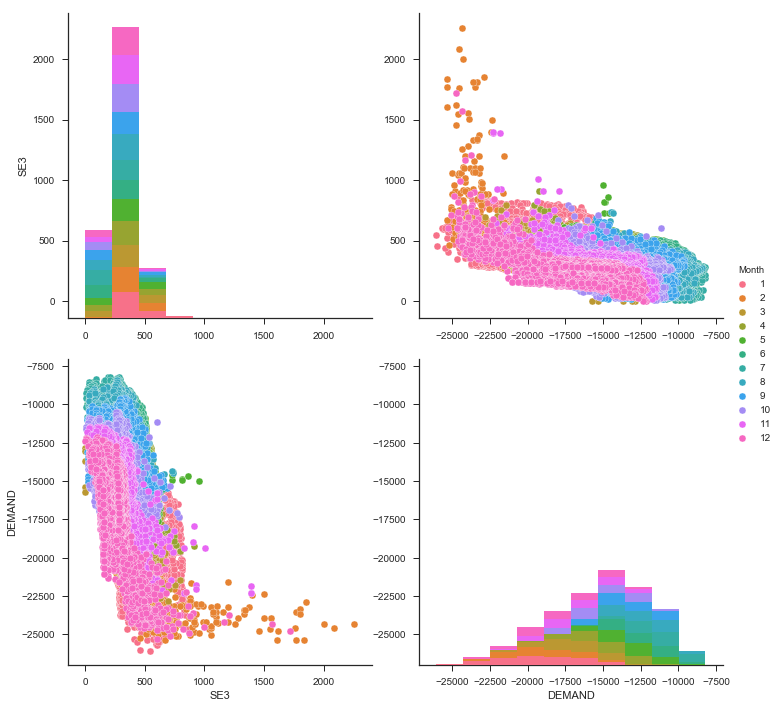

In [142]:
sns.pairplot(data, hue="Month",size=5,vars=["SE3","DEMAND"])

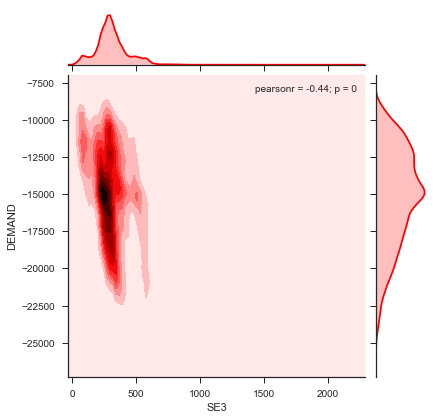

In [135]:
sns.jointplot(data["SE3"], data["DEMAND"], kind="kde", color="red")

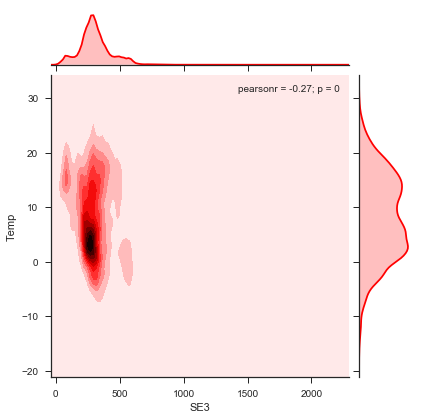

In [134]:
sns.jointplot(data["SE3"], data["Temp"], kind="kde", color="red")

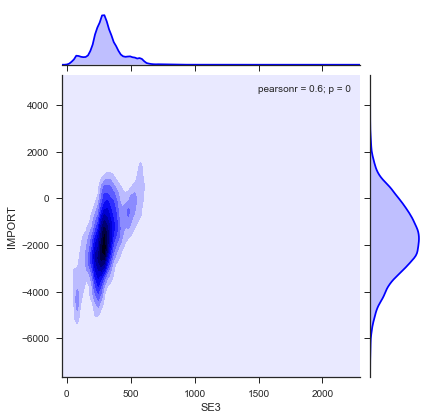

In [143]:
sns.jointplot(data["SE3"], data["IMPORT"], kind="kde", color="blue")

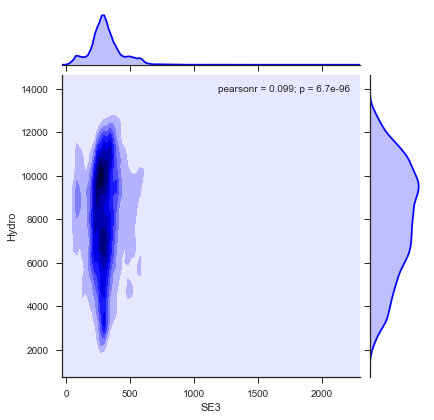

In [155]:
sns.jointplot(data["SE3"], data["Hydro"], kind="kde", color="blue", dropna="true")

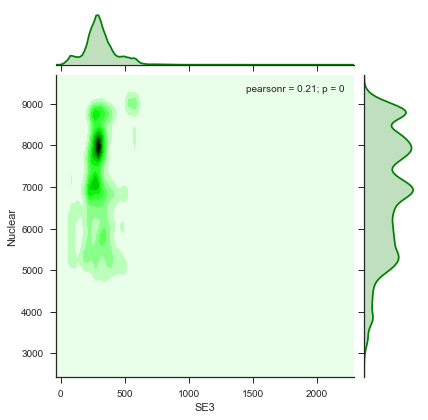

In [158]:
sns.jointplot(data["SE3"], data["Nuclear"], kind="kde", color="green", dropna="true")

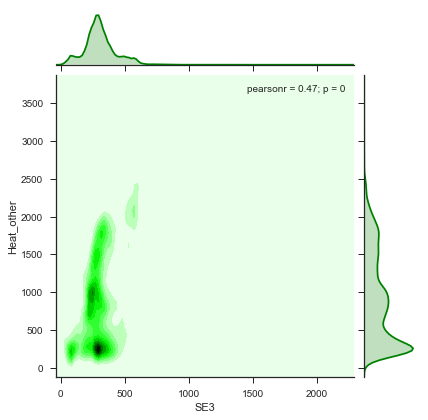

In [159]:
sns.jointplot(data["SE3"], data["Heat_other"], kind="kde", color="green", dropna="true")


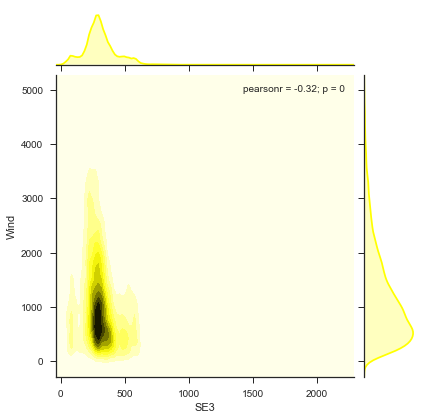

In [160]:
sns.jointplot(data["SE3"], data["Wind"], kind="kde", color="yellow", dropna="true")

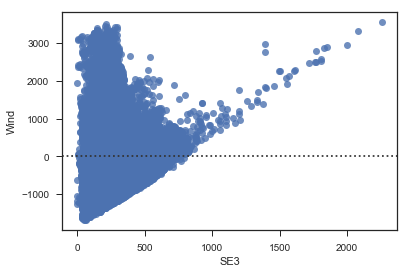

In [174]:
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
import os
from sklearn.preprocessing import OneHotEncoder

X = data[["DEMAND","Temp","Hydro", "Heat_other", "Wind"]].dropna() #Cols included: Vol-Indicator 4
X_scaled = preprocessing.scale(X)
#Y = preprocessing.scale(data["SE3"].dropna()) #Y-variable
Y = data["SE3"].dropna() #Y-variable
thres = np.mean(Y) + np.std(Y)*2 #Profitability threshold
Y_enc = [data["SE3"]>thres]
Y=pd.DataFrame(Y_enc)*1
Y=Y.T

# 1. define the network
model = Sequential() #Sequence class of layered model
model.add(Dense(5, input_dim=5, activation='sigmoid')) #dense layer 2 with 12 neurons, and 5 input (layer 1) neurons that should match X
model.add(Dense(1, activation='sigmoid')) #add (final) layer with 1 output - should match Y

# 2. compile the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. fit the network
history = model.fit(X_scaled, Y, epochs=10, batch_size=10)


Epoch 1/10
43799/43799 [==============================] - 5s 110us/step - loss: 0.1571 - acc: 0.9499
Epoch 2/10
43799/43799 [==============================] - 4s 90us/step - loss: 0.0885 - acc: 0.9602
Epoch 3/10
43799/43799 [==============================] - 4s 87us/step - loss: 0.0792 - acc: 0.9670
Epoch 4/10
43799/43799 [==============================] - 4s 87us/step - loss: 0.0751 - acc: 0.9699
Epoch 5/10
43799/43799 [==============================] - 4s 87us/step - loss: 0.0729 - acc: 0.9719
Epoch 6/10
43799/43799 [==============================] - 4s 92us/step - loss: 0.0714 - acc: 0.9735
Epoch 7/10
43799/43799 [==============================] - 4s 86us/step - loss: 0.0703 - acc: 0.9745
Epoch 8/10
43799/43799 [==============================] - 4s 89us/step - loss: 0.0694 - acc: 0.9749
Epoch 9/10
43799/43799 [==============================] - 4s 87us/step - loss: 0.0688 - acc: 0.9748
Epoch 10/10
43799/43799 [==============================] - 4s 85us/step - loss: 0.0683 - acc: 0.975

In [117]:
# 4. evaluate the network
loss, accuracy = model.evaluate(X_scaled, Y)

43799/43799 [==============================] - 1s 23us/step


In [118]:
# 5. make predictions
probabilities = model.predict(X_scaled)
predictions = [float(np.round_(x)) for x in probabilities]
accuracy = np.mean(predictions == Y)

In [119]:
accuracy

SE3    0.97283
dtype: float64

In [120]:
loss

0.075577010257213112

In [121]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y,predictions)

array([[  923,   856],
       [  334, 41686]], dtype=int64)

In [122]:
np.sum(predictions)

42542.0

In [123]:
np.sum(Y)

SE3    42020
dtype: int64

SE3    5948
dtype: int64

3.3224309295570339e-16